In [64]:
import xml.etree.ElementTree as ET
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt


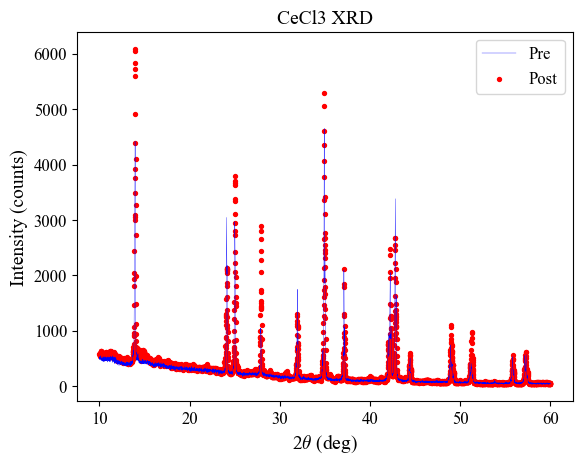

In [65]:
import xml.etree.ElementTree as ET
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# ---------- GLOBAL STYLE ----------
# Set Times New Roman as the default font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'  # Computer Modern for math symbols
plt.rcParams['font.size'] = 12  # Base font size
plt.rcParams['axes.labelsize'] = 14  # Font size for axis labels
plt.rcParams['axes.titlesize'] = 14  # Font size for titles
plt.rcParams['xtick.labelsize'] = 12  # Font size for tick labels
plt.rcParams['ytick.labelsize'] = 12  # Font size for tick labels
plt.rcParams['legend.fontsize'] = 12  # Font size for legends
# Set default line width for all plots (change this value to adjust thickness)
plt.rcParams['lines.linewidth'] = 0.25


def read_xrdml(file_path):
    """
    Read a PANalytical .xrdml file and return 2θ and intensity arrays.
    """
    file_path = Path(file_path)

    tree = ET.parse(file_path)
    root = tree.getroot()

    # Handle XML namespace
    namespace_uri = root.tag.split("}")[0].strip("{")
    ns = {"x": namespace_uri}

    data_points = root.find(".//x:dataPoints", ns)
    if data_points is None:
        raise ValueError(f"Could not find <dataPoints> in {file_path}")

    positions = data_points.find("x:positions", ns)
    intensities_elem = data_points.find("x:intensities", ns)

    if positions is None or intensities_elem is None:
        raise ValueError(f"Missing <positions> or <intensities> in {file_path}")

    start = float(positions.find("x:startPosition", ns).text)
    end = float(positions.find("x:endPosition", ns).text)

    increment_elem = positions.find("x:stepSize", ns)
    if increment_elem is None:
        increment_elem = positions.find("x:increment", ns)

    intensities_text = intensities_elem.text.strip().split()
    intensities = np.array([float(x) for x in intensities_text])

    if increment_elem is not None:
        step = float(increment_elem.text)  # not used, but fine
        two_theta = np.linspace(start, end, len(intensities))
    else:
        two_theta = np.linspace(start, end, len(intensities))

    return two_theta, intensities


def plot_three_xrd(pre_data, during_data, post_data, normalize=True):
    """
    Plot three XRD profiles (Pre, During, Post) as line plots.

    Parameters
    ----------
    pre_data, during_data, post_data : tuple
        Each is (two_theta, intensity).
    normalize : bool
        If True, scale each pattern by its own maximum intensity.
    """
    tt_pre, i_pre = pre_data
    tt_during, i_during = during_data
    tt_post, i_post = post_data

    # Normalize (optional)
    if normalize:
        i_pre = i_pre / np.max(i_pre)
        i_during = i_during / np.max(i_during)
        i_post = i_post / np.max(i_post)

    # Common 2θ grid over overlapping range
    tt_min = max(tt_pre.min(), tt_during.min(), tt_post.min())
    tt_max = min(tt_pre.max(), tt_during.max(), tt_post.max())

    num_points = min(len(tt_pre), len(tt_during), len(tt_post))
    tt_common = np.linspace(tt_min, tt_max, num_points)

    i_pre_interp = np.interp(tt_common, tt_pre, i_pre)
    i_during_interp = np.interp(tt_common, tt_during, i_during)
    i_post_interp = np.interp(tt_common, tt_post, i_post)

    # ---------- SINGLE PLOT ----------
    plt.figure(figsize=(8, 5))

    plt.plot(tt_common, i_pre_interp, label="Pre")
    plt.plot(tt_common, i_during_interp, label="During")
    plt.plot(tt_common, i_post_interp, label="Post")

    plt.xlabel(r"2$\theta$ (deg)")
    plt.ylabel("Intensity (a.u.)" if normalize else "Intensity (counts)")
    plt.title("XRD Comparison: Pre / During / Post")
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    pre_file = r"C:\Users\jeanv\OneDrive - Delft University of Technology\Uitwisseling - TUDelft\Courses\MEP\Experiments\XRDs\1H_10-60_JVB001_CeCl3_Pre.xrdml"
    during_file = r"C:\Users\jeanv\OneDrive - Delft University of Technology\Uitwisseling - TUDelft\Courses\MEP\Experiments\XRDs\7H_10-120_JVB001_CeCl3.xrdml"
    post_file = r"C:\Users\jeanv\OneDrive - Delft University of Technology\Uitwisseling - TUDelft\Courses\MEP\Experiments\XRDs\1H_10-60_JVB001_CeCl3_Post.xrdml"


    pre = read_xrdml(pre_file)
    during = read_xrdml(during_file)
    post = read_xrdml(post_file)

    plt.plot(pre[0], pre[1], color="blue")
    plt.scatter(post[0], post[1], marker='o',s=8, color="red")
    plt.xlabel(r"2$\theta$ (deg)")
    plt.ylabel("Intensity (counts)")
    plt.title("CeCl3 XRD")
    plt.legend(['Pre', 'Post'])


In [66]:
pre_file = r"C:\Users\jeanv\OneDrive - Delft University of Technology\Uitwisseling - TUDelft\Courses\MEP\Experiments\XRDs\1H_10-60_JVB001_CeCl3_Pre.xrdml"
during_file = r"C:\Users\jeanv\OneDrive - Delft University of Technology\Uitwisseling - TUDelft\Courses\MEP\Experiments\XRDs\7H_10-120_JVB001_CeCl3.xrdml"
post_file = r"C:\Users\jeanv\OneDrive - Delft University of Technology\Uitwisseling - TUDelft\Courses\MEP\Experiments\XRDs\1H_10-60_JVB001_CeCl3_Post.xrdml"

pre = read_xrdml(pre_file)
during = read_xrdml(during_file)
post = read_xrdml(post_file)

def difference_plot(pre_data, post_data):
    """
    Plot the difference between pre and post XRD patterns.

    Parameters
    ----------
    pre_data, post_data : tuple
        Each is (two_theta, intensity).
    """
    tt_pre, i_pre = pre_data
    tt_post, i_post = post_data

    # Interpolate post data onto pre data's 2θ grid
    i_post_interp = np.interp(tt_pre, tt_post, i_post)

    # Calculate difference
    difference = i_post_interp - i_pre

    return tt_pre, difference

print(difference_plot(pre, post))


(array([10.01237782, 10.02073345, 10.02908909, ..., 59.97907206,
       59.9874277 , 59.99578333], shape=(5983,)), array([63., 95., 74., ..., 12.,  1., -7.], shape=(5983,)))


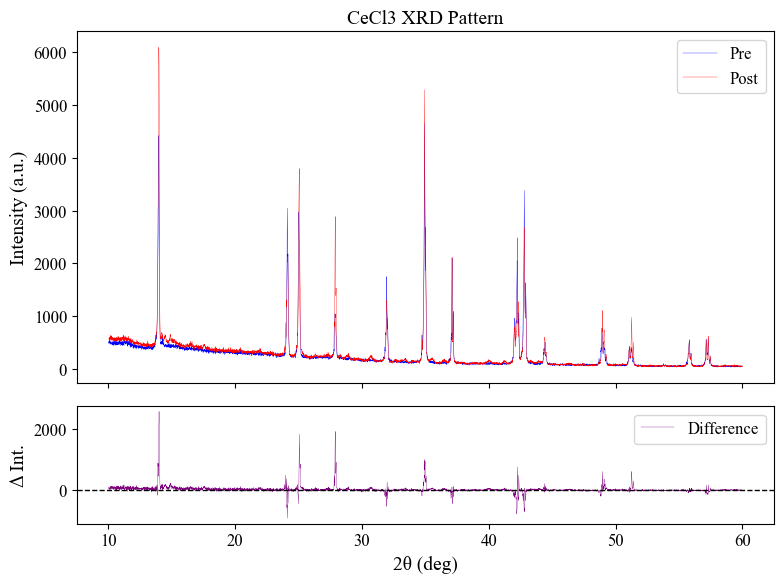

In [67]:
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={'height_ratios': [3, 1]},  # top taller than bottom
    figsize=(8, 6)
)

# --- Top: both XRD patterns ---
ax1.plot(pre[0], pre[1], color="blue", label='Pre')
ax1.plot(post[0], post[1], color="red", label='Post')
ax1.set_ylabel('Intensity (a.u.)')
ax1.legend()
ax1.set_title('CeCl3 XRD Pattern')

# --- Bottom: difference (residual) ---
ax2.plot(difference_plot(pre, post)[0], difference_plot(pre, post)[1], label='Difference', color='purple')
ax2.axhline(0, linestyle='--', linewidth=1, color="black")  # zero line
ax2.set_xlabel('2θ (deg)')
ax2.set_ylabel('Δ Int.')
ax2.legend()

plt.tight_layout()
plt.show()

(10.0, 120.0)

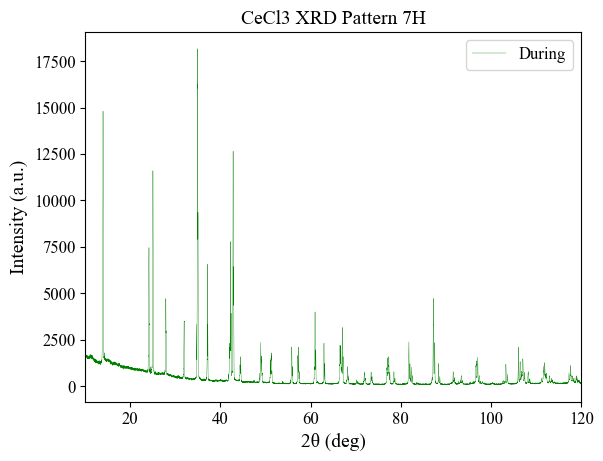

In [68]:

during = read_xrdml(during_file)

plt.plot(during[0], during[1], color="green", label='During', )
plt.ylabel('Intensity (a.u.)')
plt.legend()
plt.title('CeCl3 XRD Pattern 7H')
plt.xlabel('2θ (deg)')
plt.xlim(10, 120)